In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
from calibration_funcs import * 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from plotting_funcs import *


In [8]:
path = './data'
txt_files = list_files_with_extension(path, '.txt')

# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split(' ')[-1]
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

In [9]:
all_X.condition.unique()

array(['50', '25'], dtype=object)

In [11]:
# Define calibration parameters as variables from Rad 8 calibration
RadSlopeChange = 0.000497500472957584 #V/°C²
RadSlope0 = -0.05086460656085395 #V/°C
RadOffsetChange = 0.0012766597544389732 #V/°C
RadOffset0 = 0.039633792707224266 #V
HousingSlope = 96.62161268564931 #°C/V
HousingOffset = -48.75916244561122 #°C

In [ ]:
all_X["T_housing"] = T_housing_func(all_X["V_housing"]/1000, HousingSlope, HousingOffset)
all_X["T_rad"] = T_rad_func(all_X["V_rad_tot"]/1000, all_X["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

In [22]:
all_X = all_X[(all_X['time_index'] >= 200) | (all_X.condition != '25')]
all_X.drop("cooling_flag_1", axis=1, inplace=True)

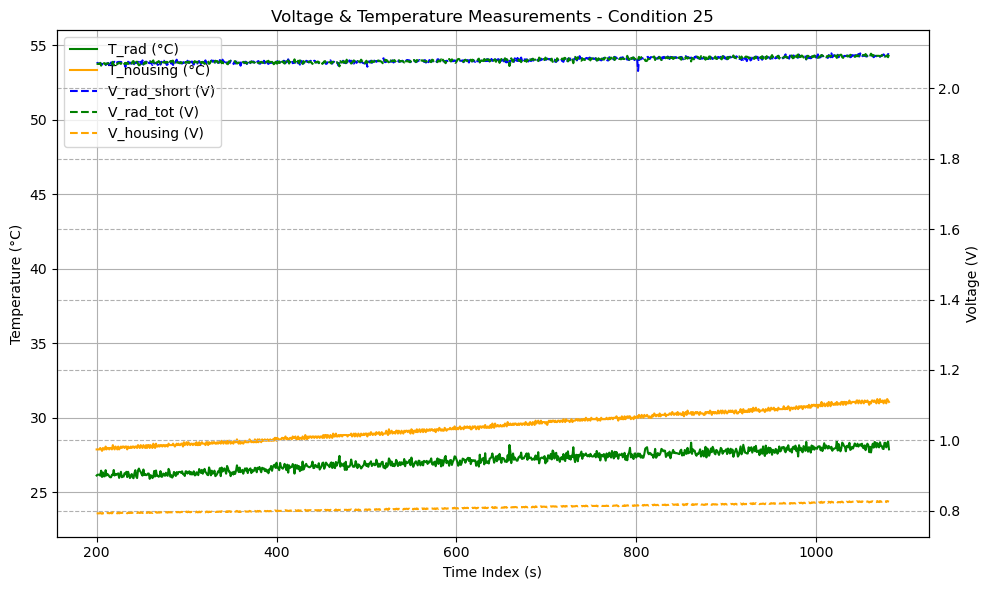

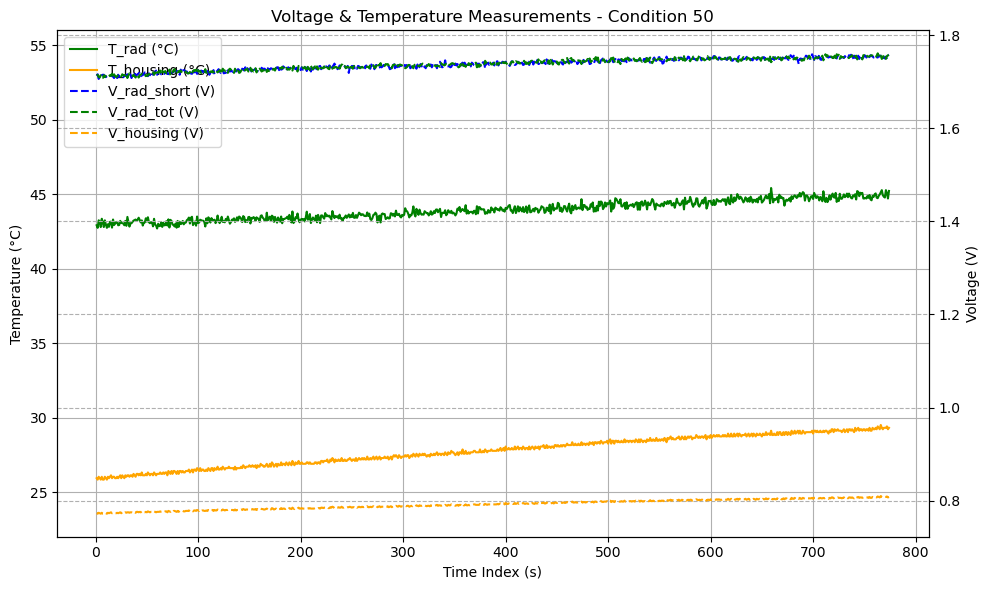

In [23]:
variables_right = ['V_rad_short', 'V_rad_tot', 'V_housing',]
variables_left = ['T_rad', 'T_housing']
y_axes_right_lims = (None, None)
y_axes_left_lims = (22, 56)

variables_colors = {
    'V_rad_short': 'blue',
    'V_rad_tot': 'green',
    'V_housing': 'orange',
    'V_diode': 'red',
    'V_spike': 'purple',
    'T_housing': 'orange',
    'T_rad': 'green',
    'T_short': 'blue',
    'T_antenna': 'purple',
    'T_diode': 'red',
    'T_end_of_cable': 'brown',
    'T_total_calc': 'black',
}
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)',
    'T_housing': 'T_housing (°C)',
    'T_rad': 'T_rad (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_short': 'T_short (°C)',
    'T_diode': 'T_diode (°C)',
    'T_end_of_cable': 'T_end_of_cable (°C)',
    'T_total_calc': 'T_total_calc (°C)',
}

conditions = sorted(all_X['condition'].unique())
for cond in conditions:
    cond_df = all_X[all_X['condition'] == cond]
    plot(
        cond_df, variables_right, y_axes_right_lims,
        variables_left, y_axes_left_lims, variables_colors, labels, plot_title = f"Voltage & Temperature Measurements - Condition {cond}"
        )

In [25]:
data_excel = pd.read_excel('./data/hot_diplexer_experiment.xlsx')

data_excel["T_housing"] = T_housing_func(data_excel["V_housing"]/1000, HousingSlope, HousingOffset)
data_excel["T_rad"] = T_rad_func(data_excel["V_rad_tot"]/1000, data_excel["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

data_excel


,T_Plate,T_Diplexer,V_rad_tot,V_housing,Bath,T_housing,T_rad
0,27.6,27.6,2075,795,25,28.055020,26.035103
1,31.4,30.3,2072,801,25,28.634749,26.782986
2,35.8,35.0,2080,815,25,29.987452,27.703949
3,40.4,39.5,2092,828,25,31.243533,28.285546
4,27.3,27.5,1712,774,50,26.025966,43.138755
5,31.0,30.1,1730,784,50,26.992182,43.396015
6,35.5,35.0,1747,797,50,28.248263,44.050493
7,40.0,39.7,1752,807,50,29.214479,44.984493


## Equations

$$
T_{rad} = T_{bath} \cdot \tau_D + T_{Diplexer} \cdot (1 - \tau_D')
$$

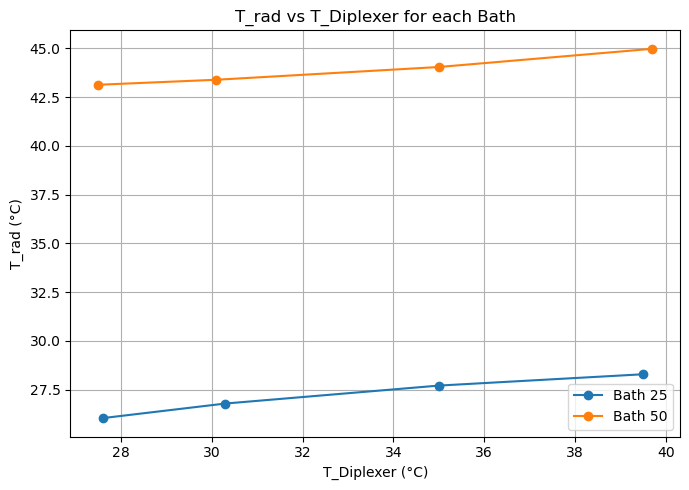

In [26]:
plt.figure(figsize=(7,5))
for bath, group in data_excel.groupby('Bath'):
    plt.plot(group['T_Diplexer'], group['T_rad'], marker='o', label=f'Bath {bath}')
plt.xlabel('T_Diplexer (°C)')
plt.ylabel('T_rad (°C)')
plt.title('T_rad vs T_Diplexer for each Bath')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
# Assign 'class' labels for each condition separately
all_X['class'] = None

for cond in all_X['condition'].unique():
    cond_mask = all_X['condition'] == cond
    cond_df = all_X[cond_mask]
    cooling_periods = cond_df[cond_df['cooling_flag_1'] == 1].copy()
    cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
    periods = cooling_periods.groupby('group')['time_index'].agg(['first', 'last']).reset_index(drop=True)
    # Use labels list, repeat if needed
    labels_25 = []
    labels_50 = ["load", "cable", "diplexer", "diplexer (no connector)*", "diplexer + cable"]
    if cond == "25":
        cond_labels = labels_25 * ((len(periods) + len(labels_25) - 1) // len(labels_25))
    elif cond == "50":
        cond_labels = labels_50 * ((len(periods) + len(labels_50) - 1) // len(labels_50))
    else:
        raise ImportError("Unknown condition")
    periods['label'] = cond_labels[:len(periods)]
    for _, row in periods.iterrows():
        mask = cond_mask & (all_X['time_index'] >= row['first']) & (all_X['time_index'] <= row['last'])
        all_X.loc[mask, 'class'] = row['label']

for cond in all_X['condition'].unique():
    print(f"\nCondition: {cond}")
    print(all_X[all_X['condition'] == cond]['class'].value_counts(dropna=False))



Condition: 50
class
None                        2359
diplexer (no connector)*     145
diplexer                     138
diplexer + cable             132
cable                        130
load                         123
Name: count, dtype: int64


In [98]:
# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
conditions = sorted(all_X_clean['condition'].unique())

for cond in conditions:
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())

Valid classes by condition:

Condition: 50
class
diplexer            138
diplexer + cable    132
cable               130
load                123
Name: count, dtype: int64



Condition 50 - Data summary by class:
  load: 123 points, time range: 0.0 - 122.0 s
  cable: 130 points, time range: 143.0 - 272.0 s
  diplexer: 138 points, time range: 293.0 - 430.0 s
  diplexer + cable: 132 points, time range: 451.0 - 582.0 s


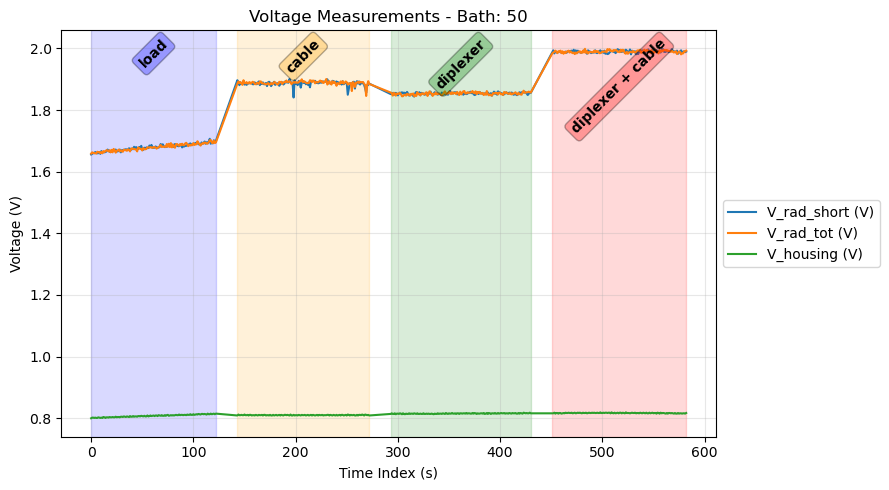

<Figure size 640x480 with 0 Axes>

In [117]:
class_order = ['load', 'cable', 'diplexer', 'diplexer + cable']
class_colors = {
    'load': 'blue',
    'cable': 'orange',
    'diplexer': 'green',
    'diplexer + cable': 'red'
}
variables = ['V_rad_short', 'V_rad_tot', 'V_housing']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1000,
    title_prefix="Voltage Measurements - Bath: ",
    ylabel="Voltage (V)"
)

In [107]:
# Calculate average V_rad_tot and V_housing for each condition and class
print("Average voltages by condition and class:")
print("="*50)

for condition in conditions:
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_voltages = condition_data.groupby('class')[['V_rad_tot', 'V_housing']].mean()
    
    print("Microvolts:")
    print(avg_voltages.round(1))
    print("-" * 30)

Average voltages by condition and class:

Condition: 50
Microvolts:
                  V_rad_tot  V_housing
class                                 
cable                1888.6      810.1
diplexer             1853.9      815.3
diplexer + cable     1989.6      816.9
load                 1678.7      807.8
------------------------------


In [108]:
# Define calibration parameters as variables
RadSlopeChange = 0.0006182511106682944  # V/°C²
RadSlope0 = -0.06051481175395883        # V/°C
RadOffsetChange = -0.0009632383570051569 # V/°C
RadOffset0 = 0.2300154917793174         # V
HousingSlope = 98.08555780332561        # °C/V
HousingOffset = -49.81626782454236      # °C

In [109]:
vna_excel_path = Path("/Users/mcy/Library/CloudStorage/OneDrive-HEPTAMEDICAL/HEPTA ADMIN - presentation_Manuel/VNA/VNA Measurements.xlsx")
vna_data = pd.read_excel(vna_excel_path)

date = "Aug 27 2025"
tau_cable = vna_data[(vna_data['DUT'] == 'Cable') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diplexer = vna_data[(vna_data['DUT'] == 'Diplexer') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diplexer_connector = vna_data[(vna_data['DUT'] == 'Diplexer + Connector') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diplexer_connector_cable = vna_data[(vna_data['DUT'] == 'Diplexer + Connector + Cable') & (vna_data["Date"] == date)]['S21 (power)'].values[0]

print(f"Cable transmission: {tau_cable:.3f}")
print(f"Diplexer transmission: {tau_diplexer:.3f}")
print(f"Diplexer + Connector transmission: {tau_diplexer_connector:.3f}")
print(f"Diplexer + Connector + Cable transmission: {tau_diplexer_connector_cable:.3f}")

Cable transmission: 0.589
Diplexer transmission: 0.953
Diplexer + Connector transmission: 0.905
Diplexer + Connector + Cable transmission: 0.535


In [110]:

print(class_order)
for cond in conditions:
    print(cond, all_X_clean[all_X_clean['condition'] == cond]['class'].unique())

['load', 'cable', 'diplexer', 'diplexer + cable']
50 ['load' 'cable' 'diplexer' 'diplexer + cable']


In [111]:
for cond in conditions:
    for class_name in class_order:
        mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == class_name)
        class_data = all_X_clean[mask]
        V_rad_tot = class_data['V_rad_tot'] / 1000
        V_housing = class_data['V_housing'] / 1000

        T_housing = T_housing_func(V_housing, HousingSlope, HousingOffset)
        T_rad = T_rad_func(V_rad_tot, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

        if class_name == "cable":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_cable)
        elif class_name == "load":
            T_cable = None
            T_tissue = T_rad
        elif class_name == "diplexer":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_diplexer_connector)
        elif class_name == "diplexer (no connector)":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_diplexer)
        elif class_name == "diplexer + cable":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_diplexer_connector_cable)

        all_X_clean.loc[mask, 'T_rad'] = T_rad
        all_X_clean.loc[mask, 'T_tissue'] = T_tissue
        all_X_clean.loc[mask, 'T_housing'] = T_housing
        all_X_clean.loc[mask, 'T_cable'] = T_cable



Condition 50 - Data summary by class:
  load: 123 points, time range: 0.0 - 122.0 s
  cable: 130 points, time range: 143.0 - 272.0 s
  diplexer: 138 points, time range: 293.0 - 430.0 s
  diplexer + cable: 132 points, time range: 451.0 - 582.0 s


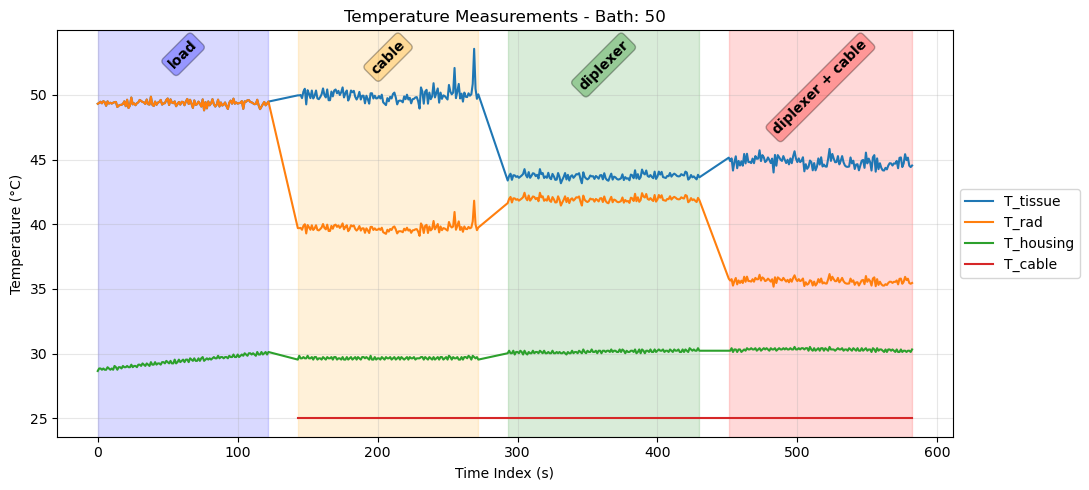

<Figure size 640x480 with 0 Axes>

In [118]:
variables = ['T_tissue', 'T_rad', 'T_housing', 'T_cable']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Temperature Measurements - Bath: ",
    ylabel="Temperature (°C)"
)

In [119]:
# Calculate average Temperature for each condition and class
print("Average temperatures by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_temperatures = condition_data.groupby('class')[['T_rad', 'T_housing', 'T_tissue']].mean()

    print("Microvolts:")
    print(avg_temperatures.round(1))
    print("-" * 30)

Average temperatures by condition and class:

Condition: 50
Microvolts:
                  T_rad  T_housing  T_tissue
class                                       
cable              39.7       29.6      50.0
diplexer           41.9       30.2      43.7
diplexer + cable   35.6       30.3      44.8
load               49.4       29.4      49.4
------------------------------


## Derive Transmissions from radiometric values

$$
T_{\text{rad}} = T_{\text{bath}} \cdot \tau + T_{\text{DUT}} \cdot (1 - \tau)
$$

$$
\tau = \frac{T_{\text{rad}} - T_{\text{DUT}}}{T_{\text{bath}} - T_{\text{DUT}}}
$$


In [120]:
# tau = (T_cable - T_rad) / (T_cable - T_bath)
T_bath = 50
T_cable = 25

tau_cable_derived = (T_cable - avg_temperatures.loc["cable", "T_rad"]) / (T_cable - T_bath)
# tau_diplexer_derived = (T_cable - avg_temperatures.loc["diplexer (no connector)", "T_rad"]) / (T_cable - T_bath)
tau_diplexer_connector_derived = (T_cable - avg_temperatures.loc["diplexer", "T_rad"]) / (T_cable - T_bath)
tau_diplexer_connector_cable_derived = (T_cable - avg_temperatures.loc["diplexer + cable", "T_rad"]) / (T_cable - T_bath)

print(f"tau_cable_derived: {tau_cable_derived:.4f} ({100*(tau_cable_derived-tau_cable)/tau_cable:.2f}% vs original)")
# print(f"tau_diplexer_derived: {tau_diplexer_derived:.4f} ({100*(tau_diplexer_derived-tau_diplexer)/tau_diplexer:.2f}% vs original)")
print(f"tau_diplexer_connector_derived: {tau_diplexer_connector_derived:.4f} ({100*(tau_diplexer_connector_derived-tau_diplexer_connector)/tau_diplexer_connector:.2f}% vs original)")
print(f"tau_diplexer_connector_cable_derived: {tau_diplexer_connector_cable_derived:.4f} ({100*(tau_diplexer_connector_cable_derived-tau_diplexer_connector_cable)/tau_diplexer_connector_cable:.2f}% vs original)")

tau_cable_derived: 0.5882 (-0.11% vs original)
tau_diplexer_connector_derived: 0.6774 (-25.16% vs original)
tau_diplexer_connector_cable_derived: 0.4243 (-20.75% vs original)


$$
\tau_{\text{D}}' \sim 0.68
$$

$$
\tau_{\text{T}}' \sim \tau_{\text{D}}' \cdot \tau_{\text{C}} = 0.68 \cdot 0.6 / 0.95 = 0.43
$$

$$
\tau_{\text{T}}' \sim 0.43
$$

In [126]:
tau_total_derived = tau_cable_derived * tau_diplexer_connector_derived / 0.95 # I realised a connector I usedo only for the cable had a high loss (tau=0.95)

for cond in conditions:
    for class_name in class_order:
        mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == class_name)
        class_data = all_X_clean[mask]
        V_rad_tot = class_data['V_rad_tot'] / 1000
        V_housing = class_data['V_housing'] / 1000

        T_housing = T_housing_func(V_housing, HousingSlope, HousingOffset)
        T_rad = T_rad_func(V_rad_tot, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

        if class_name == "cable":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_cable)
        elif class_name == "load":
            T_cable = None
            T_tissue = T_rad
        elif class_name == "diplexer":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_diplexer_connector_derived)
        elif class_name == "diplexer + cable":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_total_derived)

        all_X_clean.loc[mask, 'T_rad'] = T_rad
        all_X_clean.loc[mask, 'T_tissue'] = T_tissue
        all_X_clean.loc[mask, 'T_housing'] = T_housing
        all_X_clean.loc[mask, 'T_cable'] = T_cable



Condition 50 - Data summary by class:
  load: 123 points, time range: 0.0 - 122.0 s
  cable: 130 points, time range: 143.0 - 272.0 s
  diplexer: 138 points, time range: 293.0 - 430.0 s
  diplexer + cable: 132 points, time range: 451.0 - 582.0 s


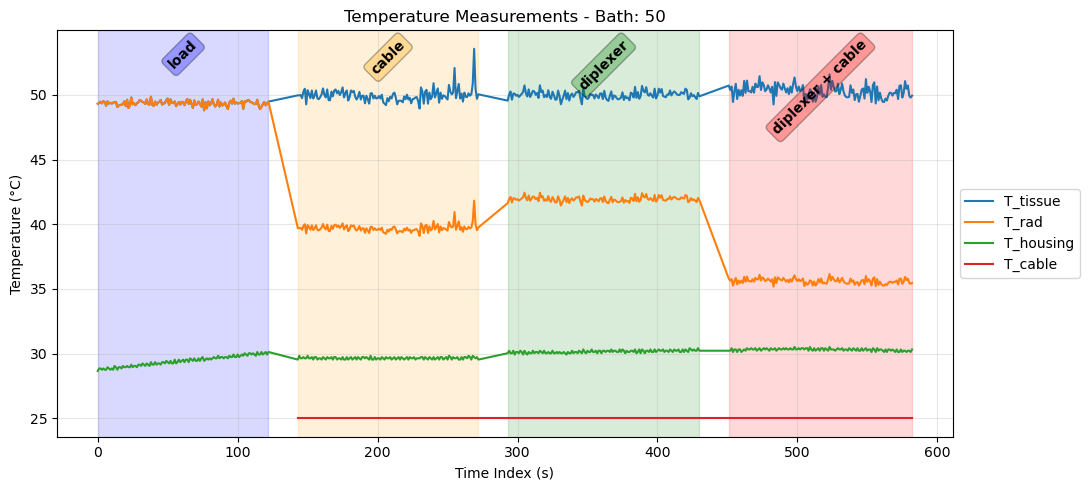

<Figure size 640x480 with 0 Axes>

In [127]:
variables = ['T_tissue', 'T_rad', 'T_housing', 'T_cable']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Temperature Measurements - Bath: ",
    ylabel="Temperature (°C)"
)

In [123]:
# Calculate average Temperature for each condition and class
print("Average temperatures by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_temperatures = condition_data.groupby('class')[['T_rad', 'T_housing', 'T_tissue']].mean()

    print("Microvolts:")
    print(avg_temperatures.round(1))
    print("-" * 30)

Average temperatures by condition and class:

Condition: 50
Microvolts:
                  T_rad  T_housing  T_tissue
class                                       
cable              39.7       29.6      50.0
diplexer           41.9       30.2      50.0
diplexer + cable   35.6       30.3      51.6
load               49.4       29.4      49.4
------------------------------
